In [ ]:
!pip install git+https://github.com/quantopian/pyfolio
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-emiyugq1
  Running command git clone -q https://github.com/quantopian/pyfolio /tmp/pip-req-build-emiyugq1
     |████████████████████████████████| 52 kB 1.5 MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75774 sha256=c2ed782be4ebda984052d6ff81a6bb3ef1115ccc04cd588318c94ae40032f699
  Stored in directory: /tmp/pip-ephem-wheel-cache-eai0c70g/wheels/2d/aa/24/c99ed55ef37c69e33815248c1622cdb81b65ec753868004c28
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39780 sha256=0a9c7baa2c936f2f565168b197dc4d544850b96610153d1db521d42610592e9b
  Stored in directory: /root/.cache/pip/wheels/d9/91/4b/654fcff57477efcf149eaca236da2fce991526cbab431bf312
Successfully built pyfolio empyrical
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wh

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf

/usr/local/lib/python3.7/dist-packages/pyfolio/pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [ ]:
RISKY_ASSETS = ['AAPL', 'IBM','MSFT', 'TWTR']
START_DATE = '2017-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [ ]:
prices_df = yf.download(RISKY_ASSETS, start = START_DATE, end = END_DATE, adjusted = True)
returns = prices_df['Adj Close'].pct_change().dropna()
portfolio_weights = n_assets * [1./n_assets]
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T), index = returns.index)

[*********************100%***********************]  4 of 4 completed


Start date,2017-01-04
End date,2018-12-28
Total months,23
,Backtest
Annual return,17.684%
Cumulative returns,38.137%
Annual volatility,21.781%
Sharpe ratio,0.86
Calmar ratio,0.70
Stability,0.87
Max drawdown,-25.319%


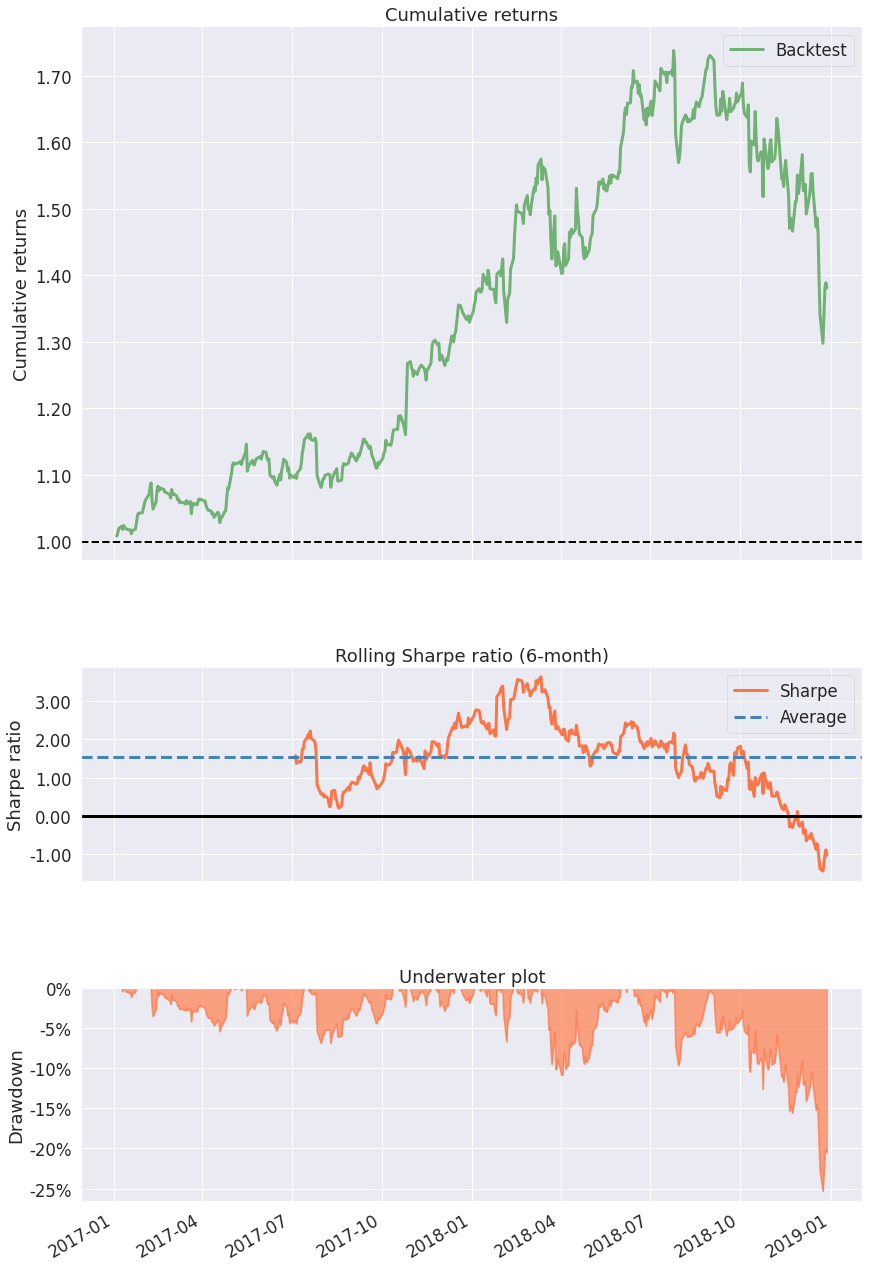

In [ ]:
pf.create_simple_tear_sheet(portfolio_returns)

Start date,2017-01-04
End date,2018-12-28
Total months,23
,Backtest
Annual return,17.684%
Cumulative returns,38.137%
Annual volatility,21.781%
Sharpe ratio,0.86
Calmar ratio,0.70
Stability,0.87
Max drawdown,-25.319%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,25.32,2018-07-25,2018-12-24,NaT,NaN
1,10.93,2018-03-12,2018-04-02,2018-06-01,60
2,6.93,2017-07-20,2017-07-31,2017-10-12,61
3,6.71,2018-02-01,2018-02-05,2018-02-12,8
4,5.48,2017-02-08,2017-04-19,2017-05-01,59


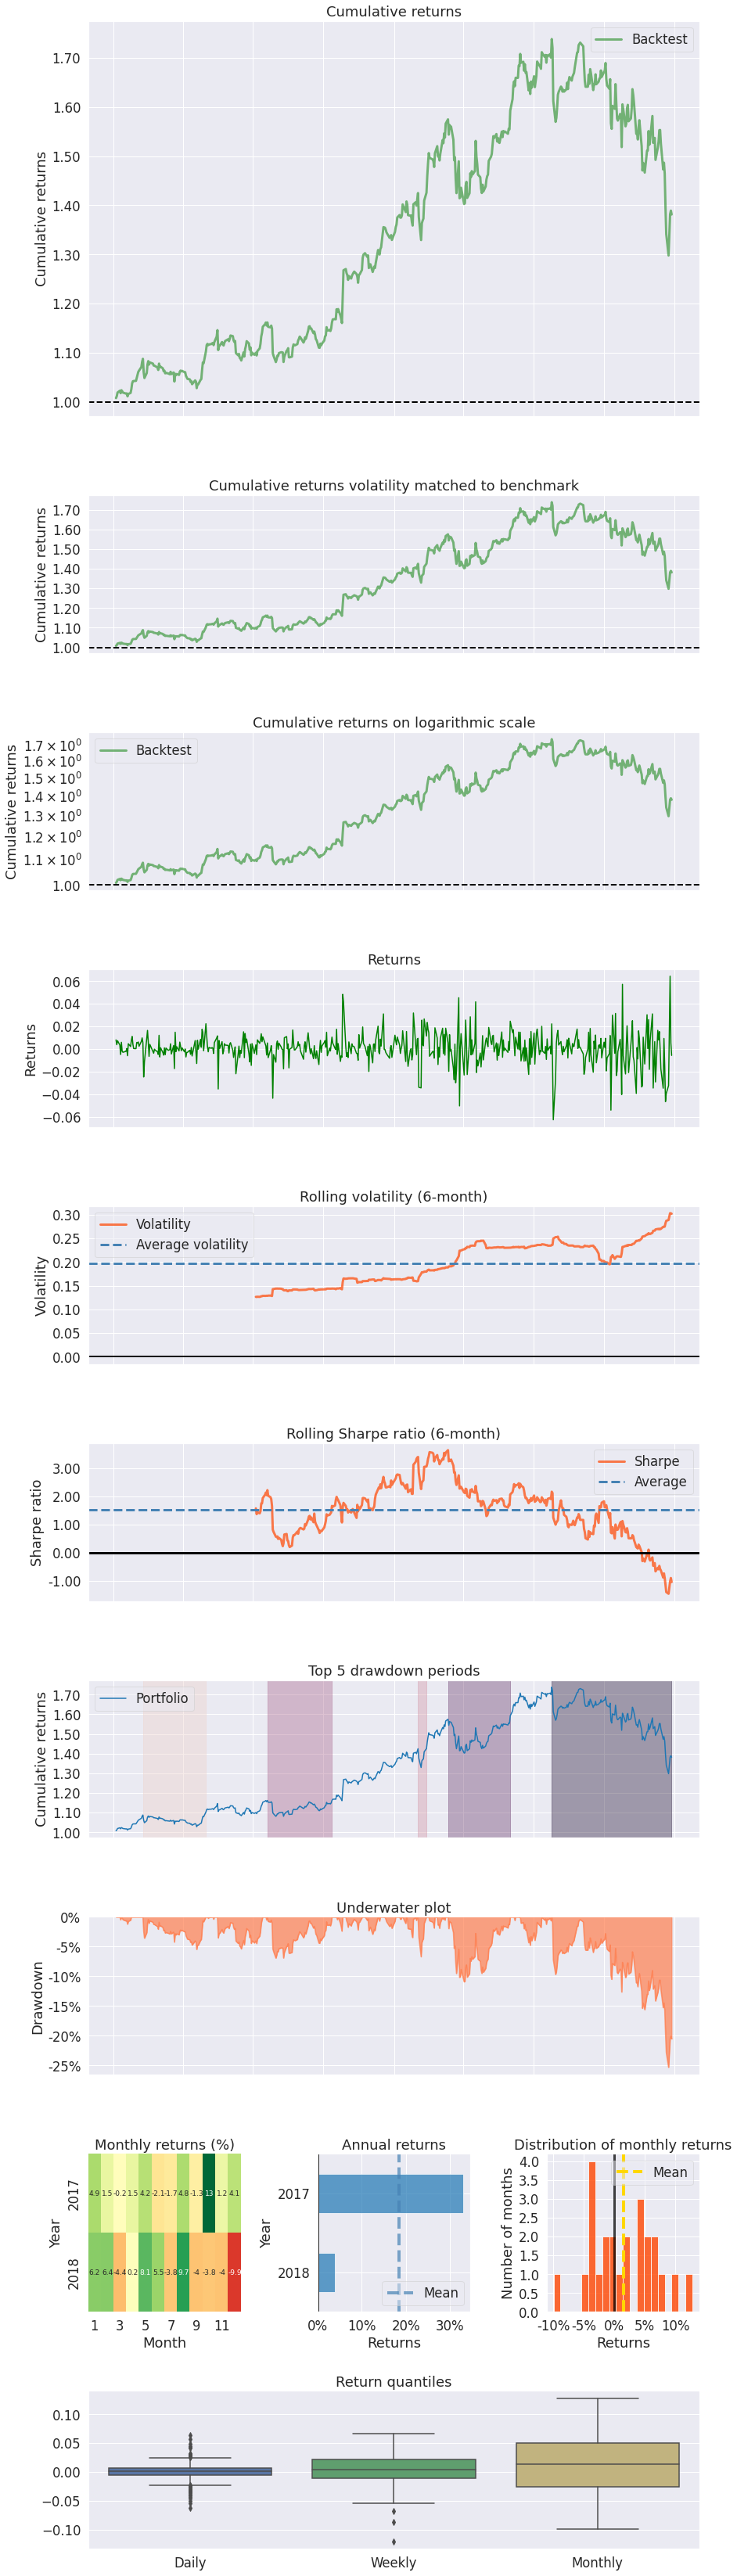

In [ ]:
pf.create_returns_tear_sheet(portfolio_returns)

In [ ]:
N_PORTFOLIOS = 10**5
N_DAYS = 252
RISKY_ASSETS = ['FB', 'MSFT', 'TSLA', 'TWTR']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

In [ ]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

In [ ]:
np.random.seed(42)
weights = np.random.random(size = (N_PORTFOLIOS, n_assets))
#print(weights)
weights /= np.sum(weights, axis = 1)[:, np.newaxis]
print(weights)

[[0.14102156 0.35796222 0.27560979 0.22540643]
 [0.12620081 0.1261813  0.04698284 0.70063506]
 [0.2613905  0.30790022 0.00895102 0.42175826]
 ...
 [0.24844023 0.35095292 0.34779874 0.05280811]
 [0.26525555 0.15257129 0.28992551 0.29224765]
 [0.12145388 0.25651504 0.39812299 0.22390809]]


In [ ]:
portf_rtns = np.dot(weights, avg_returns)
portf_vol = []

for i in range(0, len(weights)):
  portf_vol.append(np.sqrt(np.dot(weights[i].T, np.dot(cov_mat, weights[i])))) 

portf_vol = np.array(portf_vol)
portf_sharpe_ratio = portf_rtns/portf_vol

In [ ]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 'volatility': portf_vol, 'sharpe_ratio' :portf_sharpe_ratio})
portf_results_df

,returns,volatility,sharpe_ratio
0,0.148348,0.207599,0.714590
1,0.303756,0.375438,0.809071
2,0.182077,0.264670,0.687941
3,0.183079,0.208881,0.876479
4,0.147159,0.199997,0.735805
...,...,...,...
99995,0.077384,0.182883,0.423136
99996,0.280148,0.303224,0.923897
99997,0.120827,0.182114,0.663471
99998,0.231040,0.235078,0.982824


In [ ]:
N_POINTS = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), portf_results_df.returns.max(), N_POINTS)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS):
  if portf_rtns_ef[point_index] not in portf_rtns:
    indices_to_skip.append(point_index)
    continue
  matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
  portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

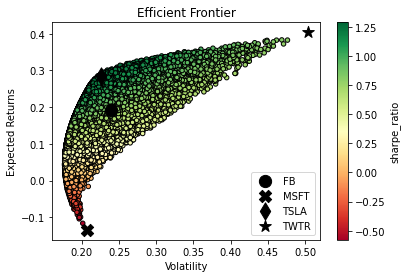

In [ ]:
import matplotlib.pyplot as plt

MARKS = ['o', 'X', 'd', '*']
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility',y='returns', c='sharpe_ratio', cmap='RdYlGn', edgecolors='black', ax=ax)
ax.set(xlabel='Volatility', ylabel='Expected Returns', title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
 ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]),y=avg_returns[asset_index], marker=MARKS[asset_index], s=150, color='black', label=RISKY_ASSETS[asset_index])
ax.legend()

In [ ]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]
min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [ ]:
print('Maximum Sharpe ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
 print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')

for x, y in zip(RISKY_ASSETS,
weights[np.argmax(portf_results_df.sharpe_ratio)]):
 print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe ratio portfolio ----
Performance
returns: 29.51% volatility: 22.89% sharpe_ratio: 128.91% 
Weights
FB: 1.86% MSFT: 0.55% TSLA: 84.64% TWTR: 12.95% 

In [ ]:
import scipy.optimize as sco
import datetime as dt

In [ ]:
def get_port_f_rtn(w, avg_rtns):
  return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_returns, cov_mat):
  return np.sqrt(np.dot(w.T, np.dot(cov_mat, w))) 

In [ ]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
  efficient_portfolios = []
  n_assets = len(avg_returns)
  args = (avg_returns, cov_mat)
  bounds = tuple((0,1) for asset in range (n_assets))
  initial_guess = n_assets * [1./n_assets]
  
  for ret in rtns_range:
    constraints = ({'type': 'eq', 'fun': lambda x:get_port_f_rtn(x, avg_rtns) - ret},
                   {'type':'eq', 'fun': lambda x: np.sum(x) - 1})
    efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, args = args, method = 'SLSQP', constraints = constraints, bounds = bounds)
    efficient_portfolios.append(efficient_portfolio)
  
  return efficient_portfolios

In [ ]:
rtns_range = np.linspace(-0.22, 0.32, 200)
efficient_portfolios = get_efficient_frontier(avg_returns, cov_mat, rtns_range)

In [ ]:
vols_range = [x['fun'] for x in efficient_portfolios]

[Text(0, 0.5, 'Expected Returns'),
 Text(0.5, 0, 'Volatility'),
 Text(0.5, 1.0, 'Efficient Frontier')]

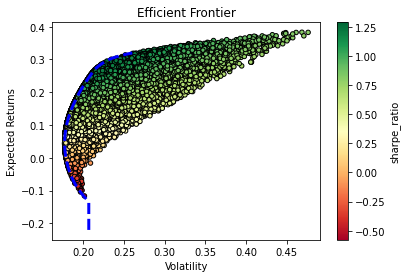

In [ ]:
fig, ax = plt.subplots()
portf_results_df.plot(kind = 'scatter', x = 'volatility', y = 'returns', c = 'sharpe_ratio', cmap = 'RdYlGn', edgecolors = 'black', ax = ax)
ax.plot(vols_range, rtns_range, 'b--', linewidth = 3)
ax.set(xlabel = 'Volatility', ylabel = 'Expected Returns', title = 'Efficient Frontier')

In [ ]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']
min_vol_portf = {'Return': min_vol_portf_rtn, 'Volatility': min_vol_portf_vol, 'Sharpe Ratio': (min_vol_portf_rtn /min_vol_portf_vol)}

In [ ]:
print('Minimum volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
 print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')

for x, y in zip(RISKY_ASSETS,
efficient_portfolios[min_vol_ind]['x']):
 print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Minimum volatility portfolio ----
Performance
Return: 4.59% Volatility: 17.69% Sharpe Ratio: 25.97% 
Weights
FB: 26.28% MSFT: 51.41% TSLA: 21.54% TWTR: 0.77% 

In [ ]:
import cvxpy as cp

In [ ]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [ ]:
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg = True)
portf_rtn_cvx = avg_returns * weights
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma* portf_vol_cvx)
problem = cp.Problem(objective_function, [cp.sum(weights) == 1, weights >=0])

In [ ]:
N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num = N_POINTS)

for i in range(N_POINTS):
  gamma.value = gamma_range[i] #Optimising for Individual Values of Gamma
  problem.solve()
  portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
  portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
  weights_ef.append(weights.value)

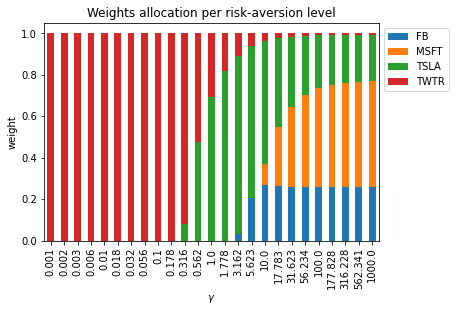

In [ ]:
weights_df = pd.DataFrame(weights_ef, columns=RISKY_ASSETS, index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True)
ax.set(title='Weights allocation per risk-aversion level', xlabel=r'$\gamma$', ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

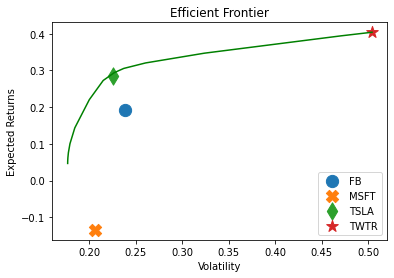

In [ ]:
fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
 plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), y=avg_returns[asset_index], marker=MARKS[asset_index], label=RISKY_ASSETS[asset_index], s=150)
ax.set(title='Efficient Frontier', xlabel='Volatility',ylabel='Expected Returns', )
ax.legend()

In [ ]:
max_leverage = cp.Parameter()
problem_with_leverage = cp.Problem(objective_function, [cp.sum(weights) == 1, cp.norm(weights,1) <= max_leverage])

In [ ]:
LEVERAGE_RANGE = [1,2,5]
len_leverage = len(LEVERAGE_RANGE)
N_POINTS = 25

portf_vol_l_ef = np.zeros((N_POINTS, len_leverage))
portf_rtn_l_ef = np.zeros((N_POINTS, len_leverage))
weights_ef = np.zeros((len_leverage, N_POINTS, n_assets))

for lev_ind, leverage in enumerate(LEVERAGE_RANGE):
  for gamma_ind in range(N_POINTS):
    max_leverage.value = leverage
    gamma.value = gamma_range[gamma_ind]
    problem_with_leverage.solve()
    portf_vol_l_ef[gamma_ind, lev_ind] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_l_ef[gamma_ind, lev_ind] = portf_rtn_cvx.value
    weights_ef[lev_ind, gamma_ind, :] = weights.value

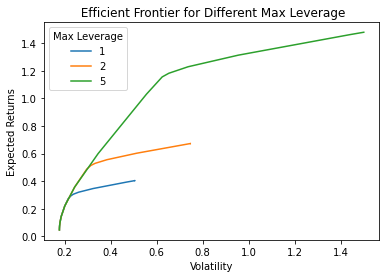

In [ ]:
fig, ax = plt.subplots()

for leverage_index, leverage in enumerate(LEVERAGE_RANGE):
  plt.plot(portf_vol_l_ef[:, leverage_index], portf_rtn_l_ef[:, leverage_index], label = f'{leverage}')
  ax.set(title = ' Efficient Frontier for Different Max Leverage', xlabel = 'Volatility', ylabel = 'Expected Returns')
ax.legend(title = 'Max Leverage')

Text(0.5, 1.0, 'Weights allocation per risk-aversion level')

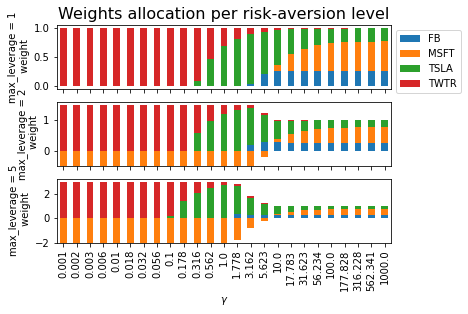

In [ ]:
fig, ax = plt.subplots(len_leverage, 1, sharex = True)

for ax_index in range(len_leverage):
 weights_df = pd.DataFrame(weights_ef[ax_index],
 columns=RISKY_ASSETS,
 index=np.round(gamma_range, 3))
 weights_df.plot(kind='bar', stacked=True, ax=ax[ax_index], legend=None)
 ax[ax_index].set(ylabel=(f'max_leverage = {LEVERAGE_RANGE[ax_index]}''\n weight'))

ax[len_leverage - 1].set(xlabel=r'$\gamma$')
ax[0].legend(bbox_to_anchor=(1,1))
ax[0].set_title('Weights allocation per risk-aversion level', fontsize=16)

In [ ]:
#Importing Data from YFin
def getData(stocks, start, end):
  stockData = pdr.get_data_yahoo(stocks, start = start, end = end)
  stockData = stockData['Close']

  returns = stockData.pct_change()
  meanReturns = returns.mean()
  covMatrix = returns.cov()
  return meanReturns, covMatrix

In [ ]:
#Defining Portfolio Performance 
def portfolioPerformance(weights, meanReturns, covMatrix):
  returns = np.sum(meanReturns * weights) * 252   #No. of Trading Day
  std = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights))) * np.sqrt(252)    
  #Converting equation above to matrix form. Variance is add-able and we use 252 as it is the number of trading days.
  return returns, std

In [ ]:
def negativeSR(weights, meanReturns, covMatrix, riskFreeRate = 0):
  pReturns, pStd = portfolioPerformance(weights, meanReturns, covMatrix)
  return -(pReturns - riskFreeRate)/pStd  
  #Returning NSharpe Ratio as -(Excess Return over Market/Risk Taken)

In [ ]:
def maxSR(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0,1)):
  # Minimise the NegativeSR by altering the weights of the portfolio
  numAssets = len(meanReturns)
  args = (meanReturns, covMatrix, riskFreeRate)
  constraints = ({'type':'eq', 'fun': lambda x : np.sum(x) - 1})
  bound = constraintSet
  bounds = list(bound for asset in range(numAssets))
  result = sco.minimize(negativeSR, numAssets * [1./ numAssets], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)

  return result

In [ ]:
def portfolioVariance(weights, meanReturns, covMatrix):
  return portfolioPerformance(weights, meanReturns, covMatrix)[1]

In [ ]:
def portfolioReturn(weights, meanReturns, covMatrix):
  return portfolioPerformance(weights, meanReturns, covMatrix)[0]

In [ ]:
def minimizeVariance(meanReturns, covMatrix, riskFreeRate = 0, constraintSet = (0,1)):
  #Minimise the portfolio variance by altering the weights/allocation of assets in the portfolio
  numAssets = len(meanReturns)
  args = (meanReturns, covMatrix)
  constraints = ({'type':'eq', 'fun': lambda x : np.sum(x) - 1})
  bound = constraintSet
  bounds = list(bound for asset in range(numAssets))
  result = sco.minimize(portfolioVariance, numAssets * [1./ numAssets], args = args, method = 'SLSQP', bounds = bounds, constraints = constraints)

  return result

In [ ]:
def efficientOpt(meanReturns, covMatrix, returnTarget, constraintSet = (0,1)):
  'For each returnTarget, we want to optimise the portfolio for minimum variance.'
  numAssets = len(meanReturns)
  args = (meanReturns, covMatrix)
  constraints = ({'type':'eq', 'fun':lambda x: portfolioReturn(x, meanReturns, covMatrix)- returnTarget},{'type':'eq', 'fun': lambda x : np.sum(x) - 1})  #Can be an inequality(>=)
  bound = constraintSet
  bounds = tuple(bound for asset in range(numAssets))
  effOpt = sco.minimize(portfolioVariance, numAssets * [1./numAssets], args = args, constraints = constraints, method = 'SLSQP', bounds = bounds)

  return effOpt

In [ ]:
stockList = ['CBA', 'BHP', 'TLS']
stocks = [stock + '.AX' for stock in stockList]

endDate = dt.datetime.now()
startDate = endDate - dt.timedelta(days = 365)

weights = np.array([0.33, 0, 0.67])

meanReturns, covMatrix = getData(stocks, start = startDate, end = endDate)
returns, std = portfolioPerformance(weights, meanReturns, covMatrix)
